## **Step 1: Lets set up a connection to the Google Drive folder so we can load our image data**

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Step 2: Import libraries**

In [0]:
# USAGE
# python train.py --dataset dataset
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import requests
import json

## **Step 3: Set up some parameters**

- **dataset**: the location of our image data
- **plot**: path to your training curve plot goes
- **model**: path to your model (make sure to give it a unique name)

In [0]:
DATASET_DIR = "/content/drive/My Drive/iotfuse2020/workshop/dataset/"
PLOT_OUTPUT = "/content/drive/My Drive/iotfuse2020/workshop/admin/plot.png"
MODEL_OUTPUT = "/content/drive/My Drive/iotfuse2020/workshop/admin/mymodel.model"
INITIAL_LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 8

## **Step 4: Load images and initialize training dataset**

1. For each image, swap color channels and resize to 224 x 224 grid (VGG input dimensions)
2. Normalize from 0->255 to 0->1 (helps with training)
3. Perform one-hot encoding
4. Do a train-test split of 80% - 20%
5. Augment the data

In [15]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(DATASET_DIR))
print(imagePaths)
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

[INFO] loading images...
['/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person651_bacteria_2543.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person939_bacteria_2864.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/IM-0033-0001-0001.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person1558_bacteria_4066.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/NORMAL2-IM-1179-0001.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person925_virus_1582.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/IM-0466-0001.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person1_bacteria_2.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person525_bacteria_2216.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/NORMAL2-IM-0869-0001.jpeg', '/content/drive/My Drive/iotfuse2020/workshop/dataset/normal/person1935_bacteria_484

## **Step 5: Create your model!**

1. Load pretrained VGG16 network
2. Remove the fully connected layer but leave the convolution layers
3. Add your own fully connected layers
4. ***Freeze*** your convolution layers to make sure they will not be updated
5. Setup an optimizer

In [0]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INITIAL_LEARNING_RATE, decay=INITIAL_LEARNING_RATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model compiled!")

[INFO] compiling model...
[INFO] model compiled!


## **Step 6: Train your model**

1. Train the model with the above training dataset
2. Use the testing dataset to evaluate model accuracy
3. Plot performance
4. Save your model locally

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 2s 481ms/step - loss: 0.6710 - accuracy: 0.5750 - val_loss: 0.7524 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 1s 143ms/step - loss: 0.9156 - accuracy: 0.4750 - val_loss: 0.7275 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 1s 144ms/step - loss: 0.8084 - accuracy: 0.5500 - val_loss: 0.7028 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 1s 146ms/step - loss: 0.6677 - accuracy: 0.5500 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 5/25
5/5 [==============================] - 1s 145ms/step - loss: 0.7048 - accuracy: 0.6250 - val_loss: 0.6737 - val_accuracy: 0.5000
Epoch 6/25
5/5 [==============================] - 1s 145ms/step - loss: 0.6753 - accuracy: 0.5750 - val_loss: 0.6548 - val_accuracy: 0.7000
Epoch 7/25
5/5 [==============================] - 1s 144ms/s

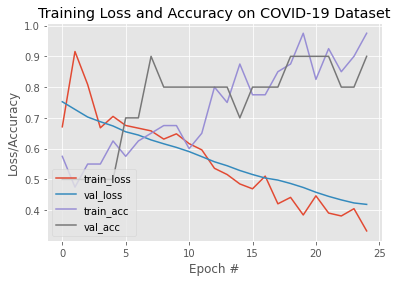

In [0]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	steps_per_epoch=len(trainX) // BATCH_SIZE,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BATCH_SIZE,
	epochs=EPOCHS)

print("Testing data dimensions:")
print(testX.shape)
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(PLOT_OUTPUT)

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(MODEL_OUTPUT, save_format="h5")

## **Step 7: Deploy your model**

1. Now that training is complete, we will deploy the model via our '*ML deployment service*'
2. Add the model binary as a file and upload it via the **deployment** HTTP endpoint
3. Response should show the **status** and the **prediction endpoint**

In [22]:
# Deploy model so it can be accessed by our application

def deploy_model(app_id):
  url = "https://iotfuse-ml.ngrok.io/deploy/{app_id}".format(app_id=app_id)
  files = {'model': open(MODEL_OUTPUT,'rb')}
  response = requests.post(url, files=files)
  print(response.text)

deploy_model("mymodel")

{"endpoint":"https://iotfuse-ml.ngrok.io/predict/mymodel","status":"Your model was successfully deployed!"}

